In [17]:
# !pip install numpy
# !pip install scipy
# !pip install matplotlib

# 1. Setup of the Analog Speech Signal

In [18]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline


audio_path = './OSR_us_000_0010_8k.wav'
sr = 8000
signal , sample_rate = librosa.load(audio_path,sr=sr)  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
time = numpy.linspace(0,3.5,signal.size)
signal.size,sample_rate

(28000, 8000)

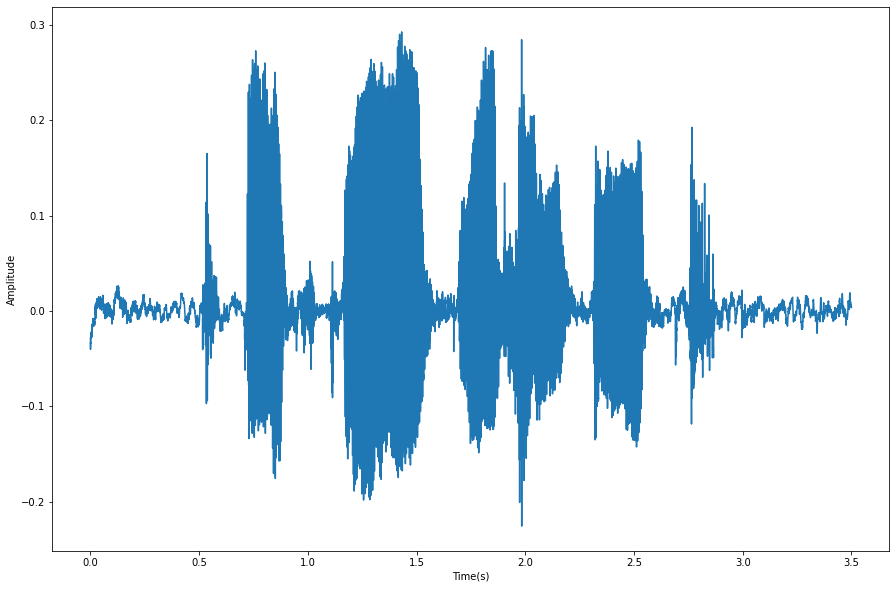

In [36]:
plt.plot(time,signal)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.rcParams["figure.figsize"] = (15,10)
plt.savefig("./plots/original_signal.png")

In [20]:
import IPython.display as ipd

# Only take for first 3.5 seconds for analysis
ipd.Audio(audio_path,)

# 2. Pre-Emphasis

In [21]:
# pre-emphasis filter on the signal to amplify the high frequencies
# Using first ordrer filter


pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
emphasized_signal.size

28000

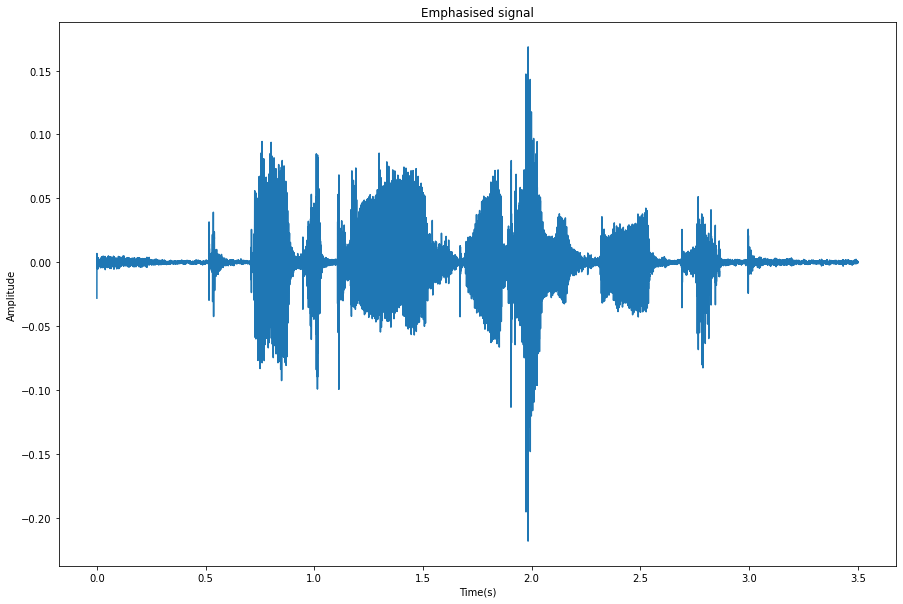

In [37]:
plt.plot(time,emphasized_signal)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Emphasised signal")
plt.rcParams["figure.figsize"] = (15,10)
plt.savefig("./plots/after_pre-emphasis.png")

# 3. Framing

200

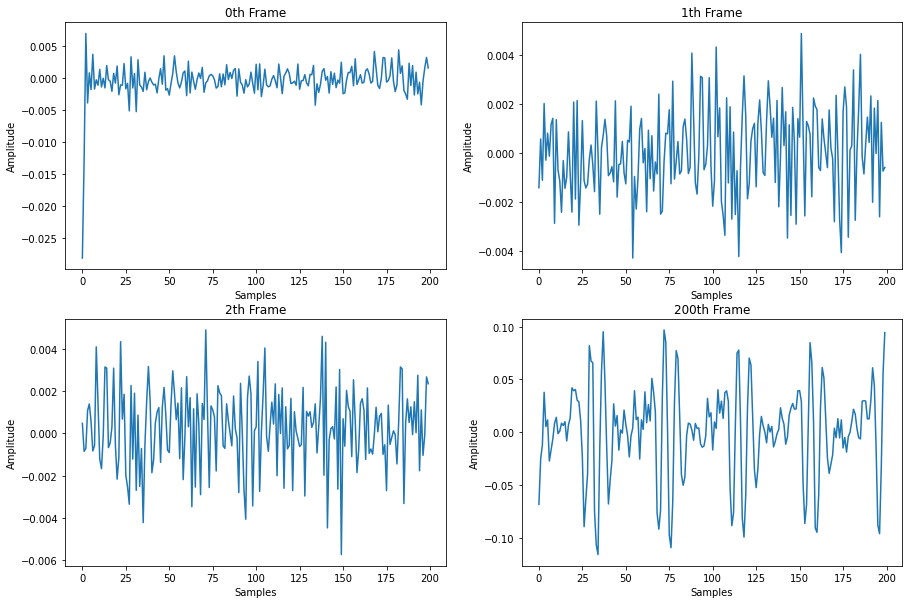

In [23]:
# split the signal into short-time frames 
#  25 milli-seconds

frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

# each frame is of 1102 length, and the entire signal length is 154350 so there will be nearly 140 frames to be calculated 
fig , ((ax0,ax1) , (ax2,ax3)) = plt.subplots(nrows = 2, ncols= 2, figsize=(15,10))

# Plot
ax0.plot(frames[0])
ax0.set(title="0th Frame",ylabel="Amplitude",xlabel="Samples")

ax1.plot(frames[1])
ax1.set(title="1th Frame",ylabel="Amplitude",xlabel="Samples")

ax2.plot(frames[2])
ax2.set(title="2th Frame",ylabel="Amplitude",xlabel="Samples")

ax3.plot(frames[200])
ax3.set(title="200th Frame",ylabel="Amplitude",xlabel="Samples")

fig.savefig('./plots/framing.png')
k = 0;
# for i in range(0,2):
#     for j in range(0,2):
#         ax[i][j].plot(frames[k])
#         k = k+1

frames_temp = frames 
len(frames[0])

# 4. Hamming Window

Frame Length : 200 


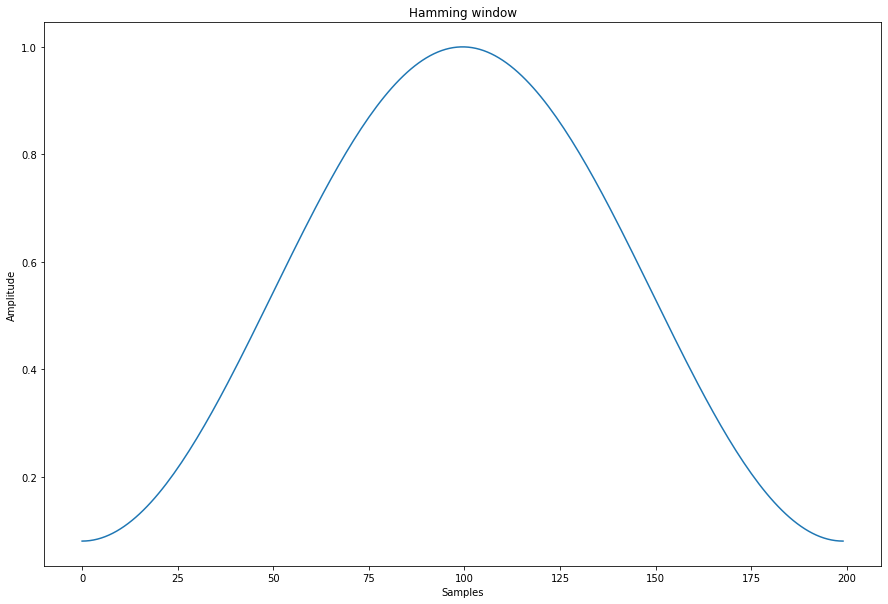

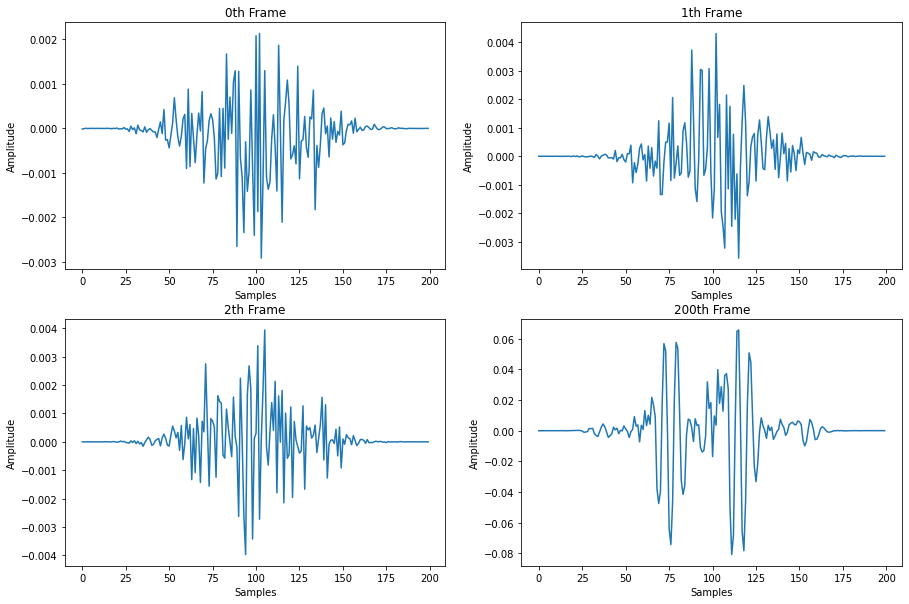

In [38]:
frames *= numpy.hamming(frame_length)
print(f"Frame Length : {frame_length} ")
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

plt.plot(numpy.hamming(frame_length))
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Hamming window")
plt.rcParams["figure.figsize"] = (15,10)
plt.savefig("./plots/Hamming_window.png")


# different frames after hammimg window
fig , ((ax0,ax1) , (ax2,ax3)) = plt.subplots(nrows = 2, ncols=2, figsize=(15,10))

# Plot
ax0.plot(frames[0])
ax0.set(title="0th Frame",ylabel="Amplitude",xlabel="Samples")

ax1.plot(frames[1])
ax1.set(title="1th Frame",ylabel="Amplitude",xlabel="Samples")

ax2.plot(frames[2])
ax2.set(title="2th Frame",ylabel="Amplitude",xlabel="Samples")

ax3.plot(frames[200])
ax3.set(title="200th Frame",ylabel="Amplitude",xlabel="Samples")
# ax3.plot(without_window[347])

fig.savefig('./plots/after_windowing.png')

# plt.figure()
# plt.plot(without_window[0])

# 5. Fourier-Transform and Power Spectrum

In [27]:
# N -point FFT on each frame to calculate the frequency spectrum

NFFT = 512

mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum


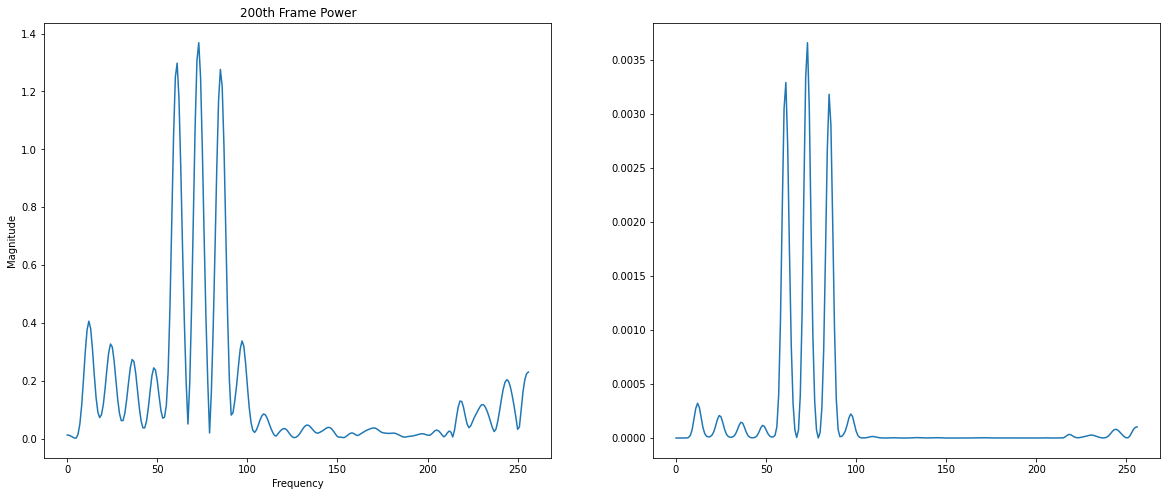

In [29]:
fig , ((ax0,ax1)) = plt.subplots(nrows = 1, ncols=2, figsize=(20,8))

# Plot
ax0.plot(mag_frames[200])
ax0.set(xlabel="Frequency",ylabel="Magnitude",title='200th Frame Magnitude')

ax1.plot(pow_frames[200])
ax0.set(xlabel="Frequency",ylabel="Magnitude",title='200th Frame Power')

fig.savefig('./plots/after_FFT.png')



# 6. Filter Banks


In [30]:
nfilt = 26  # or 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB
len(fbank)

26

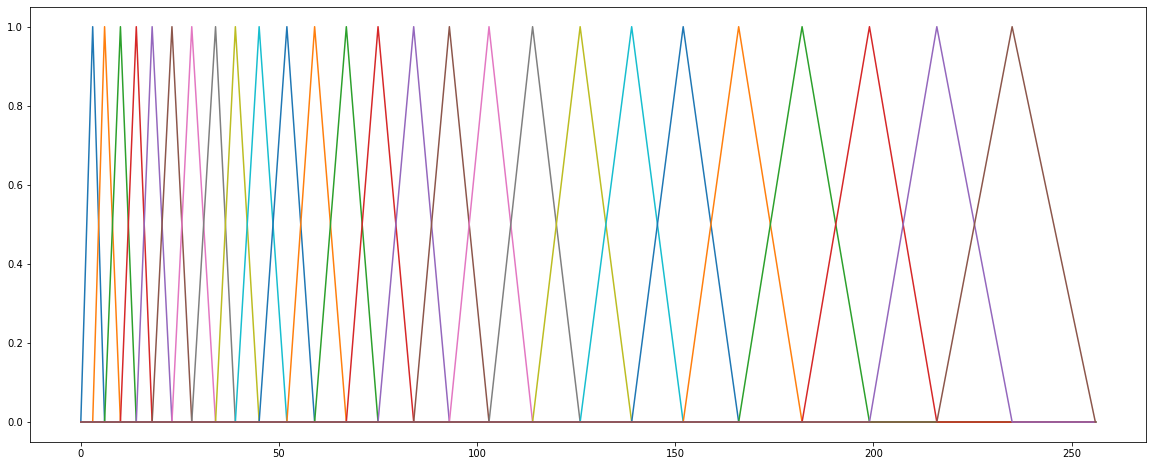

In [35]:
for i in range(0,nfilt):
    plt.plot(fbank[i],)

plt.rcParams["figure.figsize"] = (15,10)
plt.savefig("./plots/Filter_banks_26.png")


In [13]:
# for i in range(0,nfilt):
#     plt.plot(filter_banks[0])

# 7. Mel-frequency Cepstral Coefficients (MFCCs)

No of frames : 348


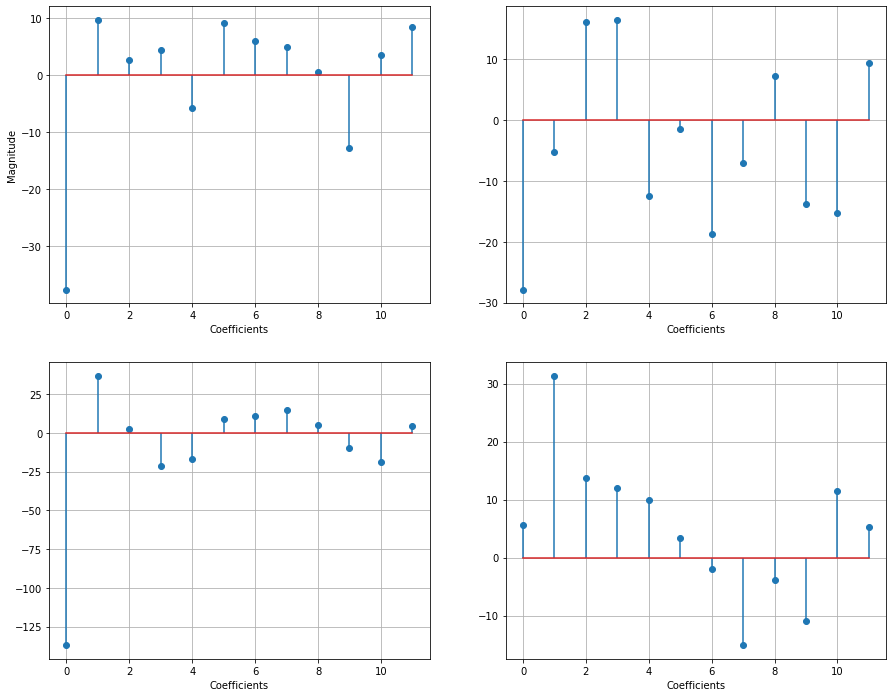

In [42]:
# Discrete Cosine Transform (DCT)

num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

# Plot
print(f"No of frames : {len(mfcc)}")
x = range(0, len(mfcc[0]))

fig , ((ax0,ax1) , (ax2,ax3)) = plt.subplots(nrows = 2, ncols=2, figsize=(15,12))

# Plot
ax0.stem(x, mfcc[0])
ax0.set(xlabel="Coefficients",ylabel="Magnitude")
ax0.grid()
# ax0.set(ylim=[-100,100])

ax1.stem(mfcc[1])
ax1.set(xlabel="Coefficients")
ax1.grid()
# ax1.set(ylim=[-100,100])

ax2.stem(mfcc[100])
ax2.set(xlabel="Coefficients")
ax2.grid()
# ax2.set(ylim=[-100,100])

ax3.stem(mfcc[347])
ax3.set(xlabel="Coefficients")
ax3.grid()
# ax3.set(ylim=[-100,100])

fig.savefig('./plots/MEL_coefficients.png')


In [15]:
len(mfcc[0])

12

In [16]:
# mfccs = librosa.feature.mfcc(signal, sr=sr)
# librosa.display.specshow(mfccs, sr=sr, x_axis='time')
# len(mfccs) , mfccs.size , mfccs